### Baseline experiment

Experiment to compare the 4 Optimization algorithms before trying to improve sparse search

In [ ]:
import HPO

import pysgpp

import matplotlib.pyplot as plt

import tensorflow as tf

import sklearn.metrics

from sklearn.model_selection import KFold

import numpy as np
import keras
from keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor, KerasClassifier


VERBOSE = 1
CV = 4#[(slice(None), slice(None))]
TESTING = False

DATASETS = []

GRID_RESULT = []
RANDOM_RESULT = []
BAYESIAN_RESULT = []
SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

GRID_COST = []
RANDOM_COST = []
BAYESIAN_COST = []
SPARSE_COST = []
SPARSE_COST_OPTIMIZED = []

### Hyperparameter space definition

In [ ]:
ITER = 3

hyperparameterspace = {
    'epochs': ["interval-int", 1, 15],
    'batch_size': ["interval-int", 10, 200],
    'optimizer__learning_rate': ["interval-log", 0.0000001, 0.1],
    #'model__neurons_per_layer': ["interval-int", 1, 100],
    #'model__number_of_layers': ["interval-int", 1, 10],
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste

In [6]:
ids = [233211, 359935, 359952, 359931, 359949, 359938]
#[359940, 317614, 359934, 359946, 359932, 233214, 359943]

def relu_advanced(x):
    return K.relu(x)

ACTIVATION_FUNCTION = relu_advanced

INITIALIZER = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0, seed=42)

valid_datasets = 0
for i in range(len(ids)):
    print("######################################################################################################################################################")
    print("Current Dataset:", (i+1), "of", len(ids), "with id:", ids[i])

    dataset = HPO.Dataset(task_id=ids[i])

    ################## MODEL AND FUNCTION DEFINITION ####################

    # Function to create model, required for KerasClassifier
    def create_model(neurons_per_layer=40, number_of_layers=1): 
        # create model
        model = Sequential()
        model.add(Dense(neurons_per_layer, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION, kernel_initializer=INITIALIZER, bias_initializer=INITIALIZER))
        for _ in range(number_of_layers):
            model.add(Dense(neurons_per_layer, activation=ACTIVATION_FUNCTION, kernel_initializer=INITIALIZER, bias_initializer=INITIALIZER))
        model.add(Dense(1, activation=None))

        optimizer = keras.optimizers.Adam(learning_rate=0.001)

        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model
    
    def evaluate_model(loss, epochs, batch_size, model_learning_rate, neurons_per_layer, number_of_layers):
        # Function to create model, required for KerasClassifier
        def create_model():
            # create model
            model = Sequential()
            model.add(Dense(neurons_per_layer, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION, kernel_initializer=INITIALIZER, bias_initializer=INITIALIZER))
            for _ in range(number_of_layers):
                model.add(Dense(neurons_per_layer, activation=ACTIVATION_FUNCTION, kernel_initializer=INITIALIZER, bias_initializer=INITIALIZER))
            model.add(Dense(1, activation=None))
            # Compile model
            
            optimizer = keras.optimizers.Adam(learning_rate=model_learning_rate)

            model.compile(loss=loss, optimizer=optimizer)
            return model


        kfold = KFold(n_splits=CV)

        X = dataset.get_X_train().tolist() + dataset.get_X_validation().tolist()
        Y = dataset.get_Y_train().tolist() + dataset.get_Y_validation().tolist()
        
        if TESTING:
            X += dataset.get_X_test().tolist()
            Y += dataset.get_Y_test().tolist()

        X = np.array(X)
        Y = np.array(Y)

        split = (kfold.split(X, Y))

        values = []

        for i, (train_index, test_index) in enumerate(split):
            X_train = X[train_index]
            Y_train = Y[train_index]

            X_val = X[test_index]
            Y_val = Y[test_index]


            model = KerasRegressor(model=create_model, verbose=0)

            model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size)

            Y_predicted = model.predict(X_val)
            error = sklearn.metrics.mean_squared_error(Y_predicted, Y_val)
            values.append(error)

            K.clear_session()
            del model

        result = sum(values)/len(values)
        return result


    def blackboxfunction(params):
        #index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
        loss = 'mean_squared_error'#hyperparameterspace_special["loss"][index]
        
        epochs = int(params[0])

        batch_size = int(params[1])

        model_learning_rate = params[2]

        neurons_per_layer = 40 # int(params[3])

        number_of_layers = 1 # int(params[4])

        return evaluate_model(loss, epochs, batch_size, model_learning_rate, neurons_per_layer, number_of_layers)
        
    ##################### Function for sparse grid search #####################

    class ExampleFunction(pysgpp.ScalarFunction):

        def __init__(self):
            super(ExampleFunction, self).__init__(len(hyperparameterspace.keys()))


        def eval(self, x):
            #index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
            loss = 'mean_squared_error'#hyperparameterspace_special["loss"][index]
            
            epochs = int(HPO.from_standard(hyperparameterspace_special["epochs"][0], hyperparameterspace_special["epochs"][1], x[0]))

            batch_size = int(HPO.from_standard(hyperparameterspace_special["batch_size"][0], hyperparameterspace_special["batch_size"][1], x[1]))

            model_learning_rate = HPO.from_standard_log(hyperparameterspace_special["optimizer__learning_rate"][0], hyperparameterspace_special["optimizer__learning_rate"][1], x[2])
            
            neurons_per_layer = 40 # int(HPO.from_standard(hyperparameterspace_special["model__neurons_per_layer"][0], hyperparameterspace_special["model__neurons_per_layer"][1], x[3]))

            number_of_layers = 1 # int(HPO.from_standard(hyperparameterspace_special["model__number_of_layers"][0], hyperparameterspace_special["model__number_of_layers"][1], x[4]))

            return evaluate_model(loss, epochs, batch_size, model_learning_rate, neurons_per_layer, number_of_layers)
            

    ##### For each dataset: run models with different budget #####

    for j in range(ITER):
        BUDGET = (j+1) * 3
        print("\n################################################## Current Budget:", BUDGET, "##################################################")

        ############################## GRID SEARCH #######################
        print("Performing grid search")
        
        model = KerasRegressor(model=create_model, verbose=0)

        optimization = HPO.GridSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        if VERBOSE > 0:
            print("Best params found by grid search:")
            print(result.best_params_)
        
        Y_predicted = result.predict(dataset.get_X_test())

        GRID_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
        GRID_COST.append(cost)

        K.clear_session()
        del model

        ########################### RANDOM SEARCH #######################
        print("Performing random search")
        
        model = KerasRegressor(model=create_model, verbose=0)

        optimization = HPO.RandomSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        if VERBOSE > 0:
            print("Best params found by random search:")
            print(result.best_params_)

        Y_predicted = result.predict(dataset.get_X_test())

        RANDOM_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
        RANDOM_COST.append(cost)

        K.clear_session()
        del model 

        ########################### BAYESIAN OPT ##################### 
        print("Performing bayesian optimization")

        optimization = HPO.BayesianOptimization(dataset, blackboxfunction, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE)


        result = optimization.fit()
        
        index_best = 0
        for m in range(len(result[1])):
            if result[1][m] == max(result[1]):
                index_best = m

        best_score = result[1][index_best]
        best_params = result[0][index_best]

        if VERBOSE > 0:
            print("With Hyperparameters: ")
            i = 0
            for key in hyperparameterspace.keys():
                if hyperparameterspace[key][0] == "list":
                    index = int(best_params[i]*(len(hyperparameterspace_special[key])-1))
                    print(key + ": " + str(hyperparameterspace_special[key][index]))
                else:
                    print(key + ": " + str(best_params[i]))
                i += 1

        TESTING = True
        BAYESIAN_RESULT.append(blackboxfunction(best_params))
        #TESTING = False

        BAYESIAN_COST.append(BUDGET)

        K.clear_session()

        ########################### SPARSE OPT ############################
        print("Performing sparse search")

        f = ExampleFunction()

        optimization = HPO.SparseGridSearchOptimization(dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=2, adaptivity=0.95, optimizer="rprop")

        result = optimization.fit()

        TESTING = True
        SPARSE_RESULT.append(f.eval(result[0]))
        SPARSE_RESULT_OPTIMIZED.append(f.eval(result[1]))
        #TESTING = False

        SPARSE_COST.append(result[2])
        SPARSE_COST_OPTIMIZED.append(result[2])

        K.clear_session()


        print(GRID_RESULT)
        print(RANDOM_RESULT)
        print(BAYESIAN_RESULT)
        print(SPARSE_RESULT)
        print(SPARSE_RESULT_OPTIMIZED)
    


KeyboardInterrupt: 

In [7]:


GRID_RESULT = [0.19596526, 0.16707046, 0.07411882, 3.1831467, 2.9952424, 2.0800803, 2.0951698, 1.5340785, 0.9681365, 114.246445, 303.95435, 93.59794, 46.09802, 95.24981, 31.730652]
RANDOM_RESULT = [0.09297073, 0.073467195, 0.04728524, 2.534172, 0.86072415, 1.4111152, 2.0468895, 1.0566909, 3.2919688, 2.5986323, 19.873098, 9.579387, 46.64293, 8.129579, 16.745747]
BAYESIAN_RESULT = [0.5161221640478688, 381.19404062386496, 131.59894200610006, 263.2244947810692, 150.8263484794116, 175.5368784979106, 544.5297899918544, 235.3466766297616, 35.50806706986935, 3396.3889083379954, 4025.3148956653304, 2512.2489730440675, 533.0600566667371, 90.44426924868596, 628.065505498477]
SPARSE_RESULT =  [4.418349813183395, 3.223900933468199, 0.11097958526922264, 67.44391313334786, 103.58357059684256, 1.605008009331356, 47.379633845340216, 42.25754210983849, 1.2102986442234192, 1486.1036569805087, 1510.304897294117, 57.72528993944508, 236.78846748410018, 185.46643303339278, 20.97375726735028]
SPARSE_RESULT_OPTIMIZED = [6.45793030081753, 5.693885799800224, 158.7845295322151, 60.05454640060361, 44.206030436438375, 442.3908332950904, 24.681463126134037, 23.971028137815335, 499.9471964506669, 1232.2530134382905, 1547.8741159289168, 4718.106943432978, 151.25101205759736, 308.32697861927136, 464.27861452663484]
    

[0.19596526, 0.16707046, 0.07411882, 3.1831467, 2.9952424, 2.0800803, 2.0951698, 1.5340785, 0.9681365, 114.246445, 303.95435, 93.59794, 46.09802, 95.24981, 31.730652]
[0.09297073, 0.073467195, 0.04728524, 2.534172, 0.86072415, 1.4111152, 2.0468895, 1.0566909, 3.2919688, 2.5986323, 19.873098, 9.579387, 46.64293, 8.129579, 16.745747]
[0.5161221640478688, 381.19404062386496, 131.59894200610006, 263.2244947810692, 150.8263484794116, 175.5368784979106, 544.5297899918544, 235.3466766297616, 35.50806706986935, 3396.3889083379954, 4025.3148956653304, 2512.2489730440675, 533.0600566667371, 90.44426924868596, 628.065505498477]
[4.418349813183395, 3.223900933468199, 0.11097958526922264, 67.44391313334786, 103.58357059684256, 1.605008009331356, 47.379633845340216, 42.25754210983849, 1.2102986442234192, 1486.1036569805087, 1510.304897294117, 57.72528993944508, 236.78846748410018, 185.46643303339278, 20.97375726735028]
[6.45793030081753, 5.693885799800224, 158.7845295322151, 60.05454640060361, 44.20

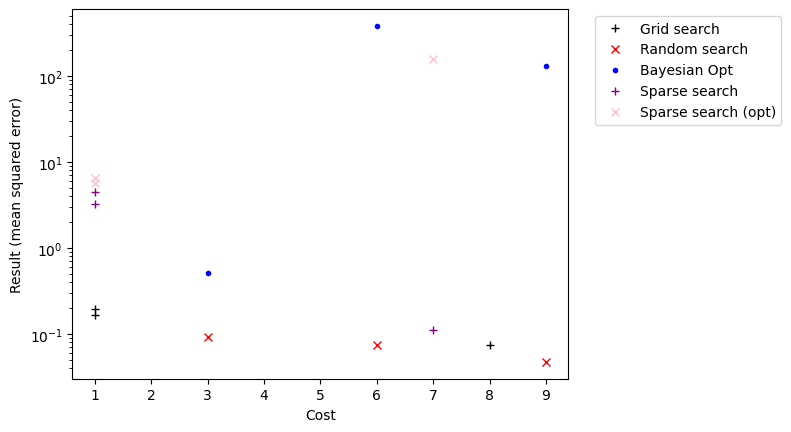

Current dataset: 1 with name id: 359935


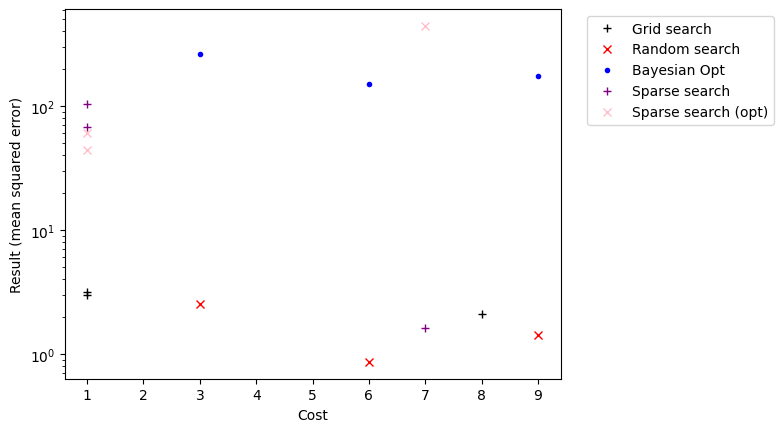

Current dataset: 2 with name id: 359952


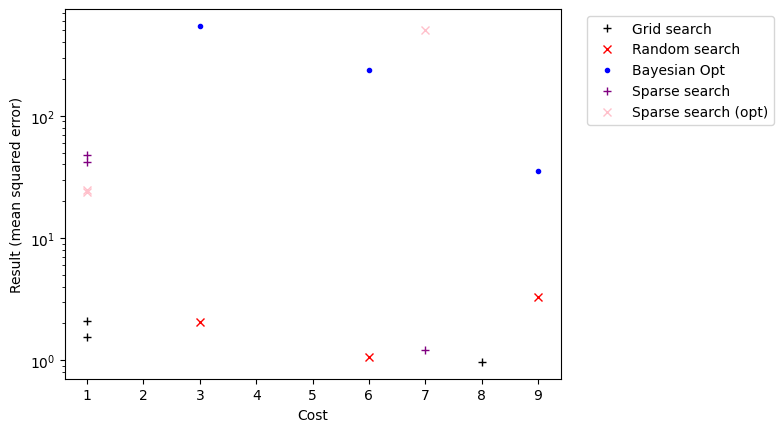

Current dataset: 3 with name id: 359940


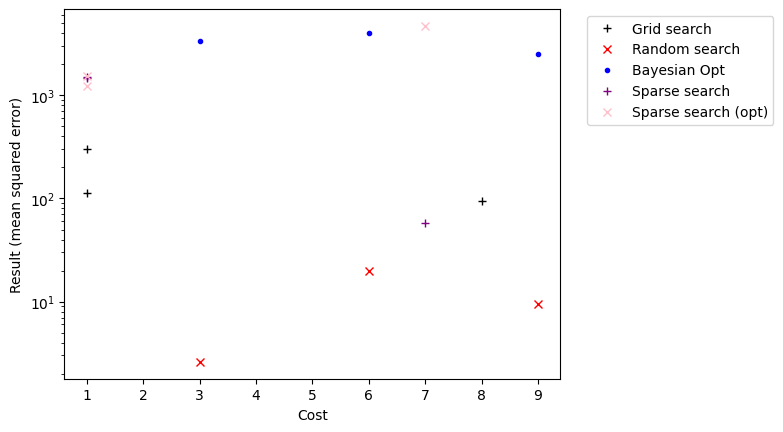

Current dataset: 4 with name id: 359931


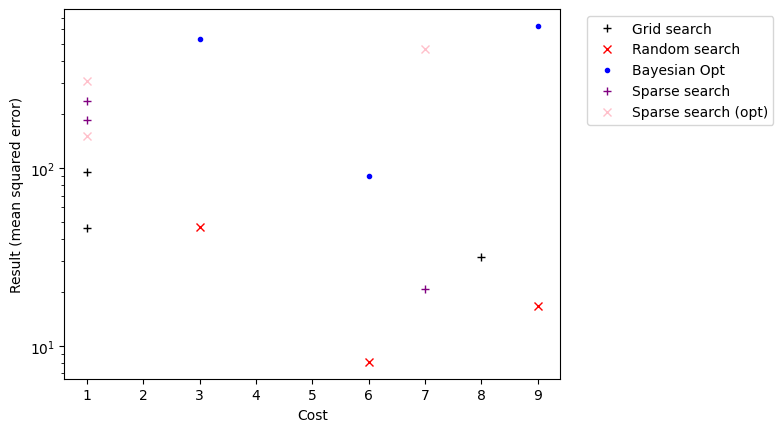

Current dataset: 5 with name id: 317614


IndexError: list index out of range

In [9]:
print(GRID_RESULT)
print(RANDOM_RESULT)
print(BAYESIAN_RESULT)
print(SPARSE_RESULT)
print(SPARSE_RESULT_OPTIMIZED)
count = 0
for i in range(len(ids)):
    print("Current dataset:", i, "with name id:", ids[i])
    for j in range(ITER):
        plt.plot(GRID_COST[count], GRID_RESULT[count], '+', color='black')
        plt.plot(RANDOM_COST[count], RANDOM_RESULT[count], 'x', color='red')
        plt.plot(BAYESIAN_COST[count], BAYESIAN_RESULT[count], '.', color='blue')
        plt.plot(SPARSE_COST[count], SPARSE_RESULT[count], '+', color='purple')
        plt.plot(SPARSE_COST_OPTIMIZED[count], SPARSE_RESULT_OPTIMIZED[count], 'x', color='pink')
        plt.xlabel("Cost")
        plt.ylabel("Result (mean squared error)")
        plt.yscale("log")
        plt.legend(["Grid search", "Random search", "Bayesian Opt", "Sparse search", "Sparse search (opt)"], bbox_to_anchor=(1.04, 1), loc="upper left")
        count += 1
    plt.show()

